# Brachistochrone

## Oracle solution

True parametric curve

$$ \left\{\begin{array}{c}
x(\theta) = R(\theta - \sin \theta)\\
y(\theta) = R(1 - \cos \theta)
\end{array}
\right. $$

In [1]:
from scipy.optimize import newton
import numpy as np

x2, y2 = 4., 2.
def f(theta):
    return y2 / x2 - (1 - np.cos(theta)) / (theta - np.sin(theta))
newton(f, np.pi / 2)

3.508368768524476

([<matplotlib.lines.Line2D at 0x7f7a322cbbb0>], 1.0343998433730988)

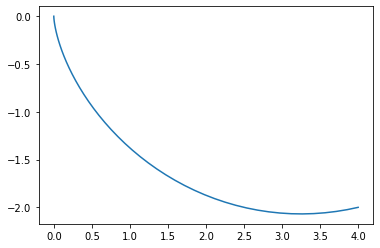

In [2]:
import matplotlib.pyplot as plt

theta2 = 3.508368768524476
N = 50
R = 2 / (1 - np.cos(theta2))
theta = np.linspace(0, theta2, N)
x = R * (theta - np.sin(theta))
y = R * (1 - np.cos(theta))

plt.plot(x, -y), R

## ODE solver

$$ y'^2 = \frac{2 R}y - 1 $$

In [3]:
from scipy.integrate import odeint, solve_ivp
from math import sqrt

def func(x, y):
    return sqrt(2 * r / y - 1)

r = 1.0343998433730988
bunch = solve_ivp(func, (0.105, 2.9), [0.309], method='RK23')

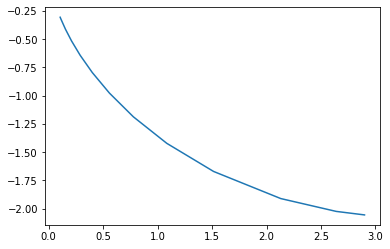

In [4]:
plt.plot(bunch.t, -bunch.y[0])

## Backpropagating through the ODE solver

In [5]:
def nn_dynamics(state, time, params):
    for r in params:
        output = jnp.sqrt(2 * r / state - 1)
    return output

In [6]:
import jax.numpy as jnp
from jax.experimental.ode import odeint

def odenet(params, inp):
    start_end_times = jnp.array([0.105, 4])
    init_state, final_state = odeint(nn_dynamics, 0.309, start_end_times, params)
    return final_state

In [7]:
from jax import vmap, jit, grad
batched_odenet = vmap(odenet, in_axes=(None, 0))

step_size = 0.01

def odenet_loss(params, inputs, targets):
    preds = batched_odenet(params, inputs)
    print(preds, targets)
    return jnp.mean(jnp.sum((preds - targets) ** 2, axis=1))

@jit
def odenet_update(params, inputs, targets):
    grads = grad(odenet_loss)(params, inputs, targets)
    return [(r - step_size * dr) for (r, dr) in zip(params, grads)]

In [8]:
# import numpy.random as npr
# odenet_params = [npr.RandomState(0).randn(1)]
odenet_params = [2.1]

In [9]:
train_iters = 25

for i in range(train_iters):
    odenet_params = odenet_update(odenet_params,
                                  np.array([[x2]]), np.array([[y2]]))
    print(odenet_params)

Traced<ShapedArray(float32[1])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[1]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f7a2469d810>, invars=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/1)>,), outvars=[<weakref at 0x7f7a2058d860; to 'JaxprTracer' at 0x7f7a2058d270>], primitive=broadcast_in_dim, params={'shape': (1,), 'broadcast_dimensions': ()}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f7a205890f0>)) Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=0/1)>
[DeviceArray(2.0592132, dtype=float32)]
Traced<ShapedArray(float32[1])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[1]), *)


In [10]:
odenet_params

[DeviceArray(1.2626846, dtype=float32)]

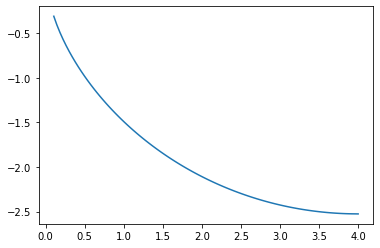

In [11]:
this_x = np.linspace(0.105, 4, 100)
# plt.plot(this_x, -odeint(nn_dynamics, 0.309, this_x, [1.15]))
plt.plot(this_x, -odeint(nn_dynamics, 0.309, this_x, odenet_params))

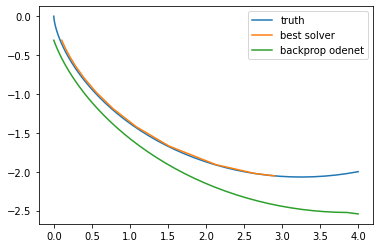

In [12]:
plt.plot(x, -y, label='truth')
plt.plot(bunch.t, -bunch.y[0], label='best solver')
plt.plot(x, -odeint(nn_dynamics, 0.309, x, odenet_params), label='backprop odenet')
plt.legend()